# NOTES

# IMPORTS

In [1]:
import os
import cv2
import imutils
import progressbar
import numpy as np
import pandas as pd
from imutils import paths
from keras import layers
from keras import models
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras import backend as K
from keras.utils import plot_model
from keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


# DATASET

## Preprocessing

In [2]:
class Preprocessor:
    
    def __init__(self, width, height, inter=cv2.INTER_AREA, dataFormat=None):
        self.width = width
        self.height = height
        self.inter = inter
        self.dataFormat = dataFormat
        self.load_widgets = ['Load Data: ', progressbar.Percentage(), ' ', progressbar.Bar(), ' ', progressbar.ETA()]
    
    # path
    def get_images_path(self, img_dir):
        return list(paths.list_images(img_dir))
    
    # data and labels
    def load_data(self, images_path):
        data = []
        labels = []
        
        # start a progress bar
        progress_load = progressbar.ProgressBar(maxval=len(images_path), widgets=self.load_widgets).start()
        
        # loop over the paths
        for (i, path) in enumerate(images_path):
            image = cv2.imread(path)
            image = self.resize(image)
            image = self.img2array(image)
            data.append(image)
            
            # extract labels
            label = path.split('/')[-1].split()[0]
            labels.append(label)
            
            # update progress bar
            progress_load.update(i)
            
        # numpy conversion
        labels = np.array(labels)
        data = np.array(data).astype('float32') / 255.0
        
        progress_load.finish()
        
        return (data, labels)
    
    # resive with aspect ratio
    def resize(self, image):
        # get height, width and initialize crop deltas
        (h, w) = image.shape[:2]
        dH = 0
        dW = 0
        
        
        
        
        # resize
        if w < h:
            image = imutils.resize(image, width=self.width, inter=self.inter)
            dH = int((image_shape[0] - self.height) / 2.0)
        else:
            image = imutils.resize(image, height=self.height, inter=self.inter)
            dW = int((image.shape[1] - self.width) / 2.0)
            
        
        # crop
        (h, w) = image.shape[:2]
        image = image[dH:h - dH, dW:w - dW]
        
        # restore spatial dimension 
        return cv2.resize(image,(self.width, self.height), interpolation=self.inter)
    
    # convert image to keras array
    def img2array(self, image):
        return img_to_array(image, data_format=self.dataFormat)
    

## Load data

In [3]:
preprocessor = Preprocessor(width=200, height=88)
image_dir = 'C:/Users/Tajr/Desktop/Data/RadonPlus/RadonTechnology/Dev/Deep Learning/Datasets/computervision/zindi/working/high/'
images_path = shuffle(preprocessor.get_images_path(image_dir))


In [4]:
(data, labels) = preprocessor.load_data(images_path)

Load Data: 100% |###############################################| Time: 0:00:55


In [5]:
data.shape

(8528, 88, 200, 3)

In [6]:
data = data.reshape(data.shape[0], data.shape[2], data.shape[1], data.shape[3])

In [7]:
# cv2.imshow('reshaped', data[0])
# cv2.waitKey(0)

In [8]:
labels[:5]

array(['MidVegetativePhase', 'MidVegetativePhase', 'MidVegetativePhase',
       'Tillering', 'Milking'], dtype='<U18')

## Binarization

In [9]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
classNames = lb.classes_

In [10]:
df = pd.DataFrame(labels, columns=[classNames])
df.head()

,Anthesis,Booting,CrownRoot,Heading,MidVegetativePhase,Milking,Tillering
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0


## Splitting

In [11]:
(trainX, test_x, trainY, test_y) = train_test_split(data, labels, test_size=0.469)
(validationX, testX, validationY, testY) = train_test_split(test_x, test_y, test_size=0.5)

# NETWORK

## Variables

In [12]:
pool_size = (2, 2)
kernel_size = (3, 3)
width = 200
height = 88
depth = 3
classes = 7

input_shape = (width, height, depth)
chann_dim = -1

# configure input shape
if K.image_data_format() == 'channels_first':
    input_shape = (depth, width, height)
    chann_dim = 1


## Net

In [13]:
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size, padding='same', input_shape=input_shape, activation='relu'))
model.add(layers.BatchNormalization(axis=chann_dim))
# model.add(layers.Conv2D(32, kernel_size, padding='same', activation='relu'))
# model.add(layers.BatchNormalization(axis=chann_dim))
model.add(layers.MaxPooling2D(pool_size=pool_size))
# model.add(layers.Dropout(0.25))

# model.add(layers.Conv2D(64, kernel_size, padding='same', activation='relu'))
# model.add(layers.BatchNormalization(axis=chann_dim))
# model.add(layers.Conv2D(64, kernel_size, padding='same', activation='relu'))
# model.add(layers.BatchNormalization(axis=chann_dim))

model.add(layers.Conv2D(64, kernel_size, padding='same', activation='relu'))
model.add(layers.BatchNormalization(axis=chann_dim))
model.add(layers.MaxPooling2D(pool_size=pool_size))
# model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, kernel_size, padding='same', activation='relu'))
model.add(layers.BatchNormalization(axis=chann_dim))
# model.add(layers.Conv2D(128, kernel_size, padding='same', activation='relu'))
# model.add(layers.BatchNormalization(axis=chann_dim))
# model.add(layers.Conv2D(256, kernel_size, padding='same', activation='relu'))
# model.add(layers.BatchNormalization(axis=chann_dim))
# model.add(layers.Conv2D(256, kernel_size, padding='same', activation='relu'))
# model.add(layers.BatchNormalization(axis=chann_dim))
model.add(layers.MaxPooling2D(pool_size=pool_size))
# model.add(layers.Dropout(0.25))

model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dropout(0.5))

# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dropout(0.5))

model.add(layers.Dense(classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 88, 32)       896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 88, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 44, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 44, 64)       18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100, 44, 64)       256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 22, 128)      

## Architecture

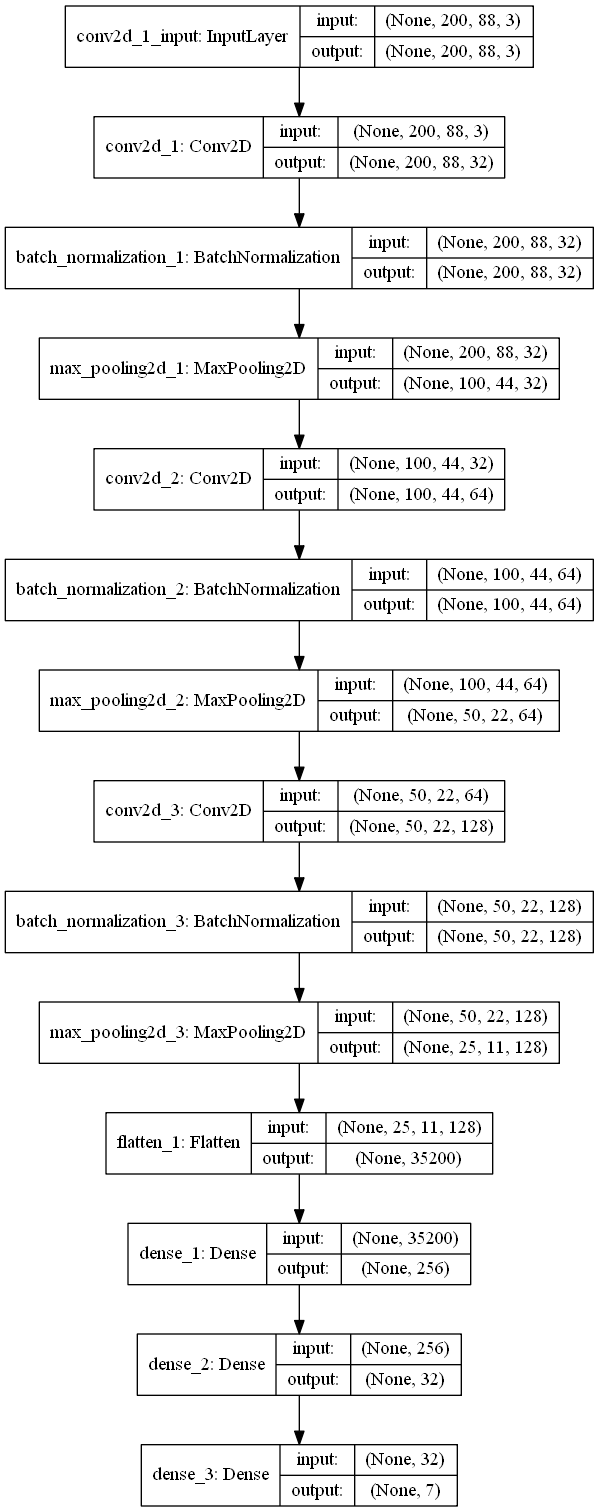

In [14]:
plot_model(model, to_file='serialized/architecture/architecture.png', show_shapes=True)

# COMPILATION

## Optimization

In [15]:
learning_rate = 0.05
opt = SGD(lr=learning_rate, momentum=0.9, nesterov=True)

## Compile

In [16]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

# TRAINING

## Class imbalance problem

In [17]:
# class imbalance problem can be solved by looking at the class weights which define how many of class A go in ration with 
# how many of class B. see the implementation below
classTotal = labels.sum(axis=0)
classWeights = classTotal.max() / classTotal

## Data augmentation

In [18]:
aug = ImageDataGenerator(rotation_range=30,width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

## Train

In [ ]:
history = model.fit_generator(aug.flow(trainX, trainY, batch_size=32), class_weight=classWeights, validation_data=(validationX, validationY), epochs=40, steps_per_epoch=len(trainX) // 32)

Epoch 1/40
 45/141 [========>.....................] - ETA: 58s - loss: 6.1225 - acc: 0.2826

# PLOTTING

In [ ]:
history_dict = history.history
epochs = np.arange(1, len(history_dict['acc']) + 1)

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.style.use('ggplot')

In [ ]:
plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Train History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.show()

# EVALUATION

In [ ]:
result = model.evaluate(testX, testY)

In [ ]:
result

# PREDICTION

# SUMMARY